# Lab 7 - Recurrent Neural Networks

Based on pytorch tutorial written by [Sean Robertson](https://github.com/spro/practical-pytorch)

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling.


In [ ]:
%matplotlib inline


from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Use dataset from https://drive.google.com/open?id=1hEABCJaEAeC2ruli4LYrGlwjsVTdHRjw
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

tcmalloc: large alloc 1073750016 bytes == 0x58af4000 @  0x7fa972c4c2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)


path = '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/*.txt'

print(findFiles(path))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Dutch.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Portuguese.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Czech.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Italian.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Irish.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Scottish.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/English.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Chinese.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Korean.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Polish.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Greek.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Russian.txt', '/content/gdrive/My Drive/nlp-classes/labs/lab-7/data/names/Japanese.txt', '/content/gdrive/My Drive/nlp-classes/labs

Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines.keys())
print(category_lines['Polish'][:])

dict_keys(['Dutch', 'Portuguese', 'Czech', 'Italian', 'Irish', 'Scottish', 'English', 'Chinese', 'Korean', 'Polish', 'Greek', 'Russian', 'Japanese', 'German', 'Spanish', 'Arabic', 'French', 'Vietnamese'])
['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz', 'Bernard', 'Bobienski', 'Bosko', 'Broz', 'Brzezicki', 'Budny', 'Bukoski', 'Bukowski', 'Chlebek', 'Chmiel', 'Czajka', 'Czajkowski', 'Dubanowski', 'Dubicki', 'Dunajski', 'Dziedzic', 'Fabian', 'Filipek', 'Filipowski', 'Gajos', 'Gniewek', 'Gomolka', 'Gomulka', 'Gorecki', 'Gorka', 'Gorski', 'Grzeskiewicz', 'Gwozdek', 'Jagoda', 'Janda', 'Janowski', 'Jaskolski', 'Jaskulski', 'Jedynak', 'Jelen', 'Jez', 'Jordan', 'Kaczka', 'Kaluza', 'Kaminski', 'Kasprzak', 'Kava', 'Kedzierski', 'Kijek', 'Klimek', 'Kosmatka', 'Kowalczyk', 'Kowalski', 'Koziol', 'Kozlow', 'Kozlowski', 'Krakowski', 'Krol', 'Kumiega', 'Lawniczak', 'Lis', 'Majewski', 'Malinowski', 'Maly', 'Marek', 'Marszaek', 'Maslanka', 'Mencher', 'Miazga', 'Michel', 'Mikolajczak', 'Moz

Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.




In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.xh = nn.Linear(input_size, hidden_size)
        self.hh = nn.Linear(hidden_size, hidden_size)
        self.hy = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = torch.tanh(self.xh(input) + self.hh(hidden))
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [ ]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.8929, -2.8052, -2.8642, -2.9976, -2.8372, -2.8149, -3.0239, -2.8797,
         -2.9503, -2.9439, -2.6527, -2.8212, -2.9289, -2.8206, -2.9146, -2.9781,
         -3.1110, -2.8786]], grad_fn=<LogSoftmaxBackward>)


For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8929, -2.8052, -2.8642, -2.9976, -2.8372, -2.8149, -3.0239, -2.8797,
         -2.9503, -2.9439, -2.6527, -2.8212, -2.9289, -2.8206, -2.9146, -2.9781,
         -3.1110, -2.8786]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Greek', 10)


We will also want a quick way to get a training example (a name and its
language):




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Shim
category = Greek / line = Petrakis
category = Russian / line = Chukhadzhyan
category = Portuguese / line = Delgado
category = Vietnamese / line = Ha
category = Polish / line = Slusarczyk
category = Chinese / line = Zhi
category = Dutch / line = Schermer
category = Polish / line = Miazga
category = Portuguese / line = Silveira


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 2.7040 Tzeizik / Czech ✗ (Russian)
10000 10% (0m 23s) 2.9757 Ohalloran / Irish ✗ (English)
15000 15% (0m 35s) 1.8342 Dalen / German ✗ (Dutch)
20000 20% (0m 47s) 1.8136 Linden / Dutch ✗ (German)
25000 25% (0m 59s) 2.5821 Iles / Greek ✗ (English)
30000 30% (1m 11s) 1.5791 Scott / English ✓
35000 35% (1m 23s) 0.1111 Batsakis / Greek ✓
40000 40% (1m 35s) 1.9875 Betts / Dutch ✗ (English)
45000 45% (1m 47s) 4.0870 Mein / Chinese ✗ (German)
50000 50% (1m 59s) 0.1939 Shalygin / Russian ✓
55000 55% (2m 11s) 2.4831 Sabbagh / German ✗ (Arabic)
60000 60% (2m 23s) 1.2560 Kaluza / Polish ✓
65000 65% (2m 35s) 1.9725 Reijnder / German ✗ (Dutch)
70000 70% (2m 47s) 1.2071 Marquerink / Dutch ✓
75000 75% (2m 59s) 1.5254 Noyes / Dutch ✗ (English)
80000 80% (3m 11s) 1.8958 Mas / Greek ✗ (Spanish)
85000 85% (3m 23s) 0.0843 Si / Korean ✓
90000 90% (3m 35s) 0.5463 Ryskamp / Dutch ✓
95000 95% (3m 47s) 0.0203 Nakamoto / Japanese ✓
100000 100% (3m 58s) 1.0825 Lamar / Czech ✗ (French)


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




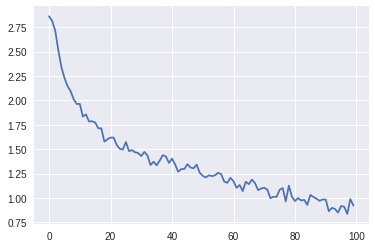

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




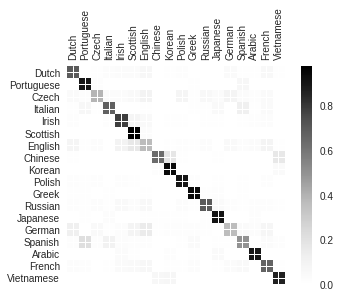

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [ ]:
def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('logprobs: (%.2f), probabilities: (%.1f) -- %s' % (value, 100*math.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Chledowski')
predict('Mikolov')
predict('Trump')
predict('Xin')
predict('Medrek')
predict('Mazur')


> Chledowski
logprobs: (-0.01), probabilities: (98.8) -- Polish
logprobs: (-4.74), probabilities: (0.9) -- Japanese
logprobs: (-7.15), probabilities: (0.1) -- Czech
logprobs: (-7.16), probabilities: (0.1) -- Italian
logprobs: (-7.69), probabilities: (0.0) -- Russian

> Mikolov
logprobs: (-0.02), probabilities: (98.3) -- Russian
logprobs: (-4.80), probabilities: (0.8) -- Polish
logprobs: (-5.91), probabilities: (0.3) -- English
logprobs: (-6.22), probabilities: (0.2) -- Greek
logprobs: (-6.43), probabilities: (0.2) -- Czech

> Trump
logprobs: (-0.86), probabilities: (42.3) -- German
logprobs: (-1.28), probabilities: (27.7) -- English
logprobs: (-2.40), probabilities: (9.0) -- French
logprobs: (-2.69), probabilities: (6.8) -- Russian
logprobs: (-2.69), probabilities: (6.8) -- Czech

> Xin
logprobs: (-0.33), probabilities: (71.7) -- Chinese
logprobs: (-1.35), probabilities: (26.0) -- Korean
logprobs: (-4.55), probabilities: (1.1) -- Vietnamese
logprobs: (-5.11), probabilities: (0.6) -- R

# Exercise (2pt)

Use top 1000 words from English and Polish to train a RNN that is able to distinguish from which language does a word come from.

- Split the dataset into train set (if i % 10 != 0) and validation set (if i % 10 == 0)

- Write a function that evaluates the accuracy of train and test sets, print these accuracies every epoch (or every ~900 iterations if you don't use epochs).

- Your model should achieve at least 85% accuracy on the test set.

- Print the plot of loss during training.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
# Use dataset from https://drive.google.com/open?id=1hEABCJaEAeC2ruli4LYrGlwjsVTdHRjw
path = '/content/gdrive/My Drive/nlp-classes/labs/lab-7/exercise/words.txt'

with open(path, 'r') as f:
  dataset = f.readlines()

dataset = [(el.replace('\n', '')).split('\t') for el in dataset]

In [ ]:
from random import shuffle

shuffle(dataset)

training, test = dataset[:int(0.9 * len(dataset))], dataset[int(0.9 * len(dataset)):]
categories = ['polish', 'english']

INPUT_SIZE = len(training)
HIDDEN_SIZE = 128
OUTPUT_SIZE = len(categories)
EPOCHS = 1000
words = {'polish': [], 'english': []}


for line in training:
  words['polish'].append(unicodeToAscii(line[1]))
  words['english'].append(unicodeToAscii(line[2]))

  

rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
for epoch in EPOCHS:
train()

[['107', 'miejsce', 'place'], ['235', 'piła', 'saw'], ['713', 'pkt', 'paragraph'], ['41', 'zrobić', 'do'], ['91', 'ponownie', 'again'], ['259', 'pomysł', 'idea'], ['540', 'serce', 'heart'], ['763', 'trudne', 'difficult'], ['382', 'Ran', 'ran'], ['496', 'rządzić', 'govern']]
[['543', 'ciężki', 'heavy'], ['533', 'sylaby', 'syllable'], ['794', 'wyobrazić', 'imagine'], ['514', 'plac', 'square'], ['377', 'suche', 'dry'], ['840', 'róża', 'rose'], ['685', 'projekt', 'design'], ['888', 'mowy', 'speech'], ['875', 'niewolnik', 'slave'], ['66', 'duży', 'large']]
900
900
['miejsce', 'piła', 'pkt', 'zrobić', 'ponownie', 'pomysł', 'serce', 'trudne', 'Ran', 'rządzić']
['place', 'saw', 'paragraph', 'do', 'again', 'idea', 'heart', 'difficult', 'ran', 'govern']


Worth reading/watching:
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
- https://www.youtube.com/watch?v=Keqep_PKrY8